<a href="https://colab.research.google.com/github/Felix-Think/SVD-and-It-s-Application/blob/main/Denoising_Image_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NOISE REDUCTION WITH SVD
Remove all unimportant concept simply by changing  the value of S to 0 with are smaller than some threshold?

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [14]:
#Add Gaussian noise to input inmage
def addNoiseToImage(image, mean = 0, stddev = 25):
    #uncomment the following three lines of code for another project
    noise = np.random.normal(mean, stddev, image.shape)
    noise = np.where(noise > 0 , np.around(noise), 0)
    noise = noise.astype(np.uint8)
    np.save('noise.npy', noise)
    noise = np.load('/content/noise.npy')
    noise = noise.astype(np.uint8)

    #add Noise to Image
    noise_img = cv2.add(noise, image)
    return noise_img

In [15]:
def convertColortoGrayScale(image, ratio_gray_scale):
    gray_image = image @ ratio_gray_scale
    return np.around(gray_image).astype(np.uint8)

In [16]:
#Quesntion 7
from google.colab.patches import cv2_imshow
color_image = cv2.imread('/content/cat.jpeg')
color_image = cv2.resize(color_image, (300, 300))
ratio_gray_scale = [0.2126, 0.7125, 0.0722 ]
gray_image = convertColortoGrayScale(color_image, ratio_gray_scale)
noise_image = addNoiseToImage(gray_image)
avg_org = np.sum(gray_image) / (gray_image.shape[0] * gray_image.shape[1])
avg_noise = np.sum(noise_image) / (noise_image.shape[0] * noise_image.shape[1])
print("avg_org", avg_org)
print("avg_noise", avg_noise)

avg_org 108.05304444444444
avg_noise 118.0007


In [17]:
def perform_image_denoise(noise_image, threshold):
    #Caculate U, S, V_T
    u, s, vt = np.linalg.svd(noise_image)
    #Remove sigma values below threshold
    s_cleaned = np.where(s > threshold, s, 0)
    s_cleaned = np.diag(s_cleaned)
    img_denoise = u @ s_cleaned @ vt
    # Instead of using @ to find img_denoise, Is it possible to use dot and the
    # broadcast porperty of np to calculate u * s
    img_denoised = np.array(np.dot((u * s_cleaned), vt)).astype('uint8')
    return img_denoise # OR img_denoised

In [18]:
def computeCosineSimilarity(img1, img2):
    img1 = img1.flatten()
    img2 = img2.flatten()
    cosine_similarity = img1.dot(img2) / (np.linalg.norm(img1) * np.linalg.norm(img2))
    return cosine_similarity

In [19]:
def compute_mean_squared_error(img1, img2):
    return np.sqrt(np.sum(np.square(img1, img2)) / (img1.shape[0] * img1.shape[1]))

In [20]:
def find_best_sigma_image_denoise(noise_image, orignal_image, metric = 0, sigma_range= 1000):
    #Caculate U , S, V_T
    u, s, vt = np.linalg.svd(noise_image)

    #Select the best threshold that has minimum error RMS
    evaluation_history = []
    for i in range(1, sigma_range):
        s_cleaned = np.where(s > i, s, 0)
        image_denoised = np.array(np.dot((u * s_cleaned), vt), dtype=int)

        if metric == 0:
            similarity = computeCosineSimilarity(image_denoised, orignal_image)
            evaluation_history.append(similarity)
        else:
            image_denoised = image_denoised.astype(np.uint8)
            orignal_image = orignal_image.astype(np.uint8)
            error = compute_mean_squared_error(image_denoised, orignal_image)
            evaluation_history.append(error)
    if metric == 0:
        best_sigma = evaluation_history.index(max(evaluation_history))
    else:
        best_sigma = evaluation_history.index(min(evaluation_history))
    return best_sigma, evaluation_history


In [21]:
def main_application(metric, sigma_range):
    #Read color image
    color_image = cv2.imread('/content/cat.jpeg')

    #Resize color image tp(300, 300)
    color_image= cv2.resize(color_image, (300, 300))
    #convert Image to Grayscale
    ratio_gray_scale = [0.2126, 0.7125, 0.0722 ]
    gray_image = convertColortoGrayScale(color_image, ratio_gray_scale)

    #Save resized grayscale image to file gray_image.png
    cv2.imwrite('gray_image.png', gray_image)

    #Add Gauusion noise to gray image
    noise_gray_image = addNoiseToImage(gray_image)

    #Save noise grayscale image to file noise_gray_image.png
    cv2.imwrite('noise_gray_image.png', noise_gray_image)

    best_threshold, evaluation_history = find_best_sigma_image_denoise(noise_gray_image, gray_image, metric, sigma_range)
    print("best_threshold", best_threshold)
    denoise_image = perform_image_denoise(noise_gray_image, best_threshold)
    cv2.imwrite('denoise_image.png', denoise_image)
    plt.plot(evaluation_history)
    plt.xlabel('Threshold')
    if metric == 0:
        plt.ylabel('Cosine Similarity')
    else:
        plt.ylabel('RMS')

    plt.title('Evaluation History')
    plt.show()


best_threshold 527


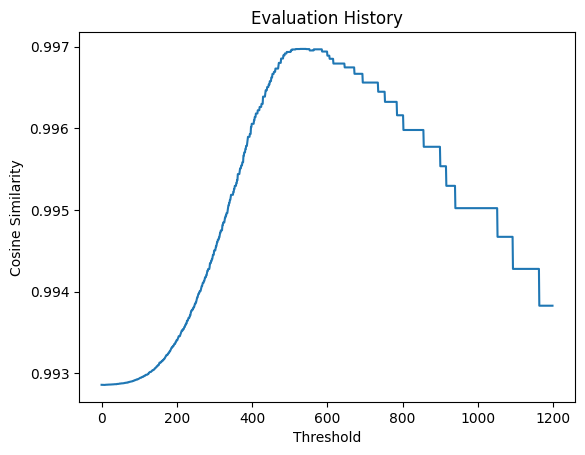

In [22]:
main_application(0, 1200)

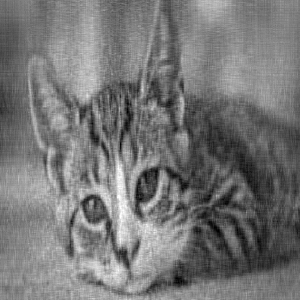

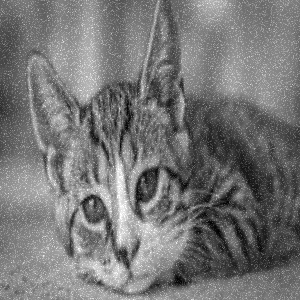

In [23]:
#Show image after and before denoise
cv2_imshow(cv2.imread('/content/denoise_image.png'))
cv2_imshow(cv2.imread('/content/noise_gray_image.png'))